In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts, plot_lifetimes


# Data Preparation

In [107]:
df = pd.read_csv('../data.csv')
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [108]:
df = df.assign(
    time = df['tenure'], 
    event = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
    ).drop(['tenure', 'Churn'], axis=1)


## Censoring

Text(0.5, 1.0, 'Births and deaths of our clients')

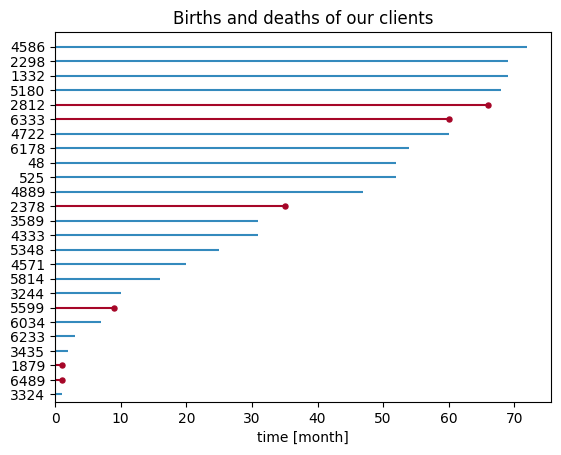

In [155]:
df_sample = df.sample(25)
ax = plot_lifetimes(df_sample['time'], df_sample['event'])
ax.set_xlabel("time [month]")
ax.set_title("Births and deaths of our clients" )

In above figure, the red lines denote the lifespan of clients where churn has been observed, and the blue lines denote the lifespan of the right-censored clients (churn have not been observed). 

## Kaplan-Meier Estimator 

<Axes: xlabel='time [month]', ylabel='Probability of Retention [%]'>

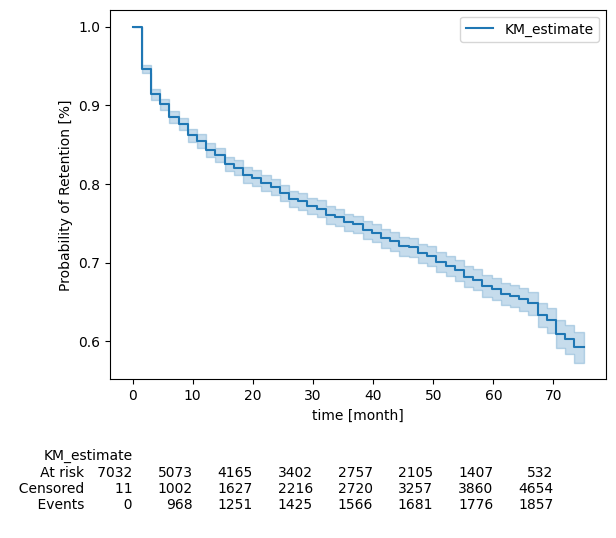

In [154]:
kmf = KaplanMeierFitter()
timeline = np.linspace(0, 75)
kmf.fit(
    durations = df['time'], 
    event_observed = df['event'],
    timeline = timeline,
)
ax = kmf.plot_survival_function()
ax.set_ylabel('Probability of Retention [%]')
ax.set_xlabel('time [month]')

add_at_risk_counts(kmf, ax=ax, fontsize=10, rows_to_show=["At risk", "Censored", "Events"])

## Compairing KM-plots [Example 1]

0    2625
1     930
Name: event, dtype: int64
0    2549
1     939
Name: event, dtype: int64


Text(0.5, 0, 'Churn Indicator [1=Yes, 0=No]')

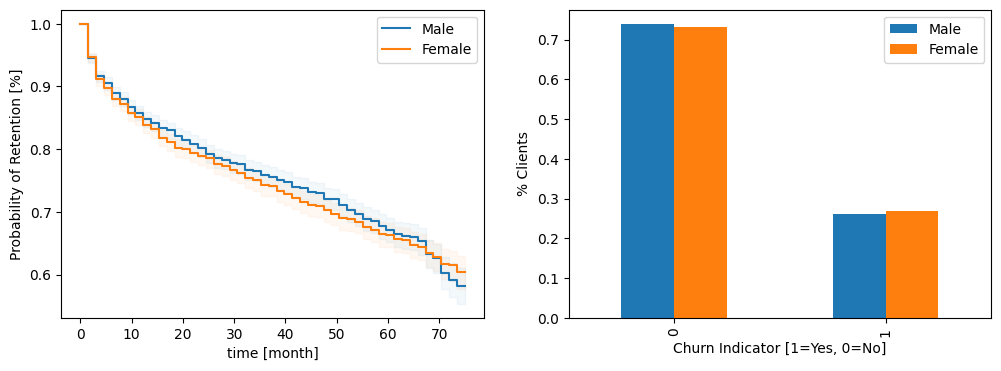

In [153]:

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ind_split = df["gender"].eq('Male')


kmf1.fit(df[ind_split]['time'], event_observed=df[ind_split]['event'], timeline=timeline, label="Male")
kmf1.plot(ci_alpha=0.05, ax=ax[0])

kmf2.fit(df[~ind_split]['time'], event_observed=df[~ind_split]['event'], timeline=timeline, label="Female")
kmf2.plot(ci_alpha=0.05, ax=ax[0])

ax[0].set_ylabel('Probability of Retention [%]')
ax[0].set_xlabel('time [month]')

labels = ["Male", "Female"]
print(sum_g1 :=df[ind_split]['event'].value_counts())
print(sum_g2 := df[~ind_split]['event'].value_counts())

df_bar = pd.DataFrame(
    [(2625/sum_g1.sum(), 2549/sum_g2.sum()), (930/sum_g1.sum(), 939/sum_g2.sum())], 
    index=[0, 1], columns=labels
).plot.bar(ax=ax[1]);

ax[1].set_ylabel('% Clients')
ax[1].set_xlabel('Churn Indicator [1=Yes, 0=No]')

## Compairing KM-plots [Example 2]

0    2733
1     669
Name: event, dtype: int64
0    2441
1    1200
Name: event, dtype: int64


Text(0.5, 0, 'Churn Indicator [1=Yes, 0=No]')

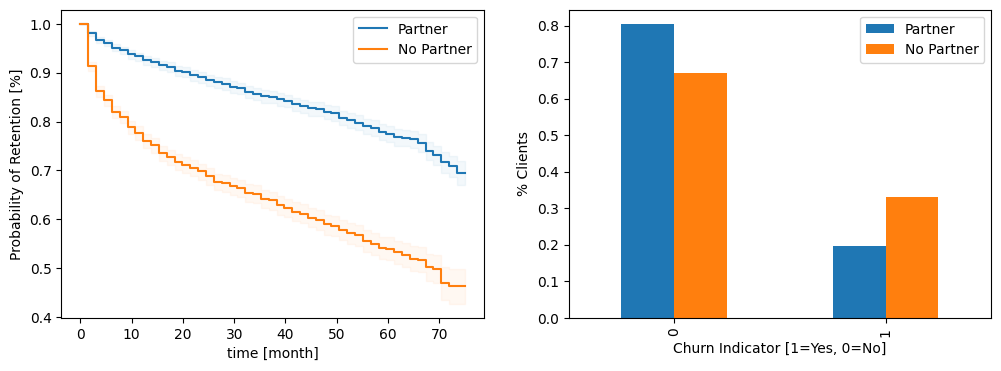

In [152]:

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ind_split = df["Partner"].eq('Yes')

kmf1.fit(df[ind_split]['time'], event_observed=df[ind_split]['event'], timeline=timeline, label="Partner")
kmf1.plot(ci_alpha=0.05, ax=ax[0])

kmf2.fit(df[~ind_split]['time'], event_observed=df[~ind_split]['event'], timeline=timeline, label="No Partner")
kmf2.plot(ci_alpha=0.05, ax=ax[0])

ax[0].set_ylabel('Probability of Retention [%]')
ax[0].set_xlabel('time [month]')

print(sum_g1 :=df[ind_split]['event'].value_counts())
print(sum_g2 := df[~ind_split]['event'].value_counts())

labels = ["Partner", "No Partner"]
df_bar = pd.DataFrame(
    [(2733/sum_g1.sum(), 2441/sum_g2.sum()), (669/sum_g1.sum(), 1200/sum_g2.sum())], 
    index=[0, 1], columns=labels
).plot.bar(ax=ax[1]);

ax[1].set_ylabel('% Clients')
ax[1].set_xlabel('Churn Indicator [1=Yes, 0=No]')

## Multivariate Churn Analysis [Cox Proportional Hazard]:

In [156]:
from lifelines import CoxPHFitter

In [178]:
cph = CoxPHFitter()
formula = """C(OnlineBackup) + SeniorCitizen + C(Partner) + C(Dependents) + C(PhoneService) + C(Contract) + C(PaymentMethod)"""
cph.fit(df, duration_col='time', event_col='event', formula=formula)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -14056.01
         time fit was run = 2023-12-13 11:46:32 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
C(Contract)[T.One year]                      -1.90       0.15       0.09            -2.07            -1.73                 0.13                 0.18
C(Contract)[T.Two year]                      -3.74       0.02       0.16            -4.05            -3.42                 0.02                 0.03
C(Dependents)[T.Yes]                         -0.07       0.94       0.07            -0.20             0.07                 0.82                 1.07
C(OnlineBackup)[T.No internet service]       -0.76       0.47       0.10            -0.96            -0.55                 0.38                 0.57
C(OnlineBackup)[T.Yes]                       -0.72       0.49       0.05            -0.83            -0.62                 0.44                 0.54
C(Partner)[T.Yes]                            -0.57       0.56       0.05            -0.68            -0.47                 0.51                 0.63
C(PaymentMethod)[T.Credit card (automatic)]  -0.06       0.94       0.09            -0.24             0.12                 0.79                 1.13
C(PaymentMethod)[T.Electronic check]          0.67       1.96       0.07             0.54             0.81                 1.71                 2.25
C(PaymentMethod)[T.Mailed check]              0.55       1.73       0.09             0.38             0.72                 1.46                 2.05
C(PhoneService)[T.Yes]                        0.16       1.17       0.08            -0.00             0.31                 1.00                 1.37
SeniorCitizen                                -0.00       1.00       0.06            -0.11             0.10                 0.89                 1.11

                                              cmp to      z      p   -log2(p)
covariate                                                                    
C(Contract)[T.One year]                         0.00 -22.16 <0.005     359.16
C(Contract)[T.Two year]                         0.00 -23.14 <0.005     390.96
C(Dependents)[T.Yes]                            0.00  -0.96   0.34       1.57
C(OnlineBackup)[T.No internet service]          0.00  -7.28 <0.005      41.48
C(OnlineBackup)[T.Yes]                          0.00 -13.29 <0.005     131.38
C(Partner)[T.Yes]                               0.00 -10.49 <0.005      83.05
C(PaymentMethod)[T.Credit card (automatic)]     0.00  -0.66   0.51       0.97
C(PaymentMethod)[T.Electronic check]            0.00   9.57 <0.005      69.61
C(PaymentMethod)[T.Mailed check]                0.00   6.29 <0.005      31.56
C(PhoneService)[T.Yes]                          0.00   1.92   0.06       4.18
SeniorCitizen                                   0.00  -0.08   0.93       0.10
---
Concordance = 0.84
Partial AIC = 28134.02
log-likelihood ratio test = 3194.06 on 11 df
-log2(p) of ll-ratio test = inf